In [ ]:

import json
import math
import os
import cv2
from PIL import Image
import numpy as np
from keras import layers
from keras.applications import ResNet50,MobileNet, DenseNet201, InceptionV3, NASNetLarge, InceptionResNetV2, NASNetMobile
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
from tqdm import tqdm
import tensorflow as tf
from keras import backend as K
import gc
from functools import partial
from sklearn import metrics
from collections import Counter
import json
import itertools
%matplotlib inline

In [ ]:
#loading and preprocessing
def Dataset_loader(DIR, RESIZE, sigmaX=10):
    IMG = []
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
    for IMAGE_NAME in tqdm(os.listdir(DIR)):
        PATH = os.path.join(DIR,IMAGE_NAME)
        _, ftype = os.path.splitext(PATH)
        if ftype == ".jpg":
            img = read(PATH)

            img = cv2.resize(img, (RESIZE,RESIZE))

            IMG.append(np.array(img))
    return IMG

benign_train = np.array(Dataset_loader('/content/drive/MyDrive/programs/data/train/benign',224))
malign_train = np.array(Dataset_loader('/content/drive/MyDrive/programs/data/train/malignant',224))
benign_test = np.array(Dataset_loader('/content/drive/MyDrive/programs/data/test/benign',224))
malign_test = np.array(Dataset_loader('/content/drive/MyDrive/programs/data/test/malignant',224))

100%|██████████| 300/300 [00:04<00:00, 74.92it/s] 


In [ ]:
# create label
benign_train_label = np.zeros(len(benign_train))
malign_train_label = np.ones(len(malign_train))
benign_test_label = np.zeros(len(benign_test))
malign_test_label = np.ones(len(malign_test))

X_train = np.concatenate((benign_train, malign_train), axis = 0)
Y_train = np.concatenate((benign_train_label, malign_train_label), axis = 0)
X_test = np.concatenate((benign_test, malign_test), axis = 0)
Y_test = np.concatenate((benign_test_label, malign_test_label), axis = 0)

s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
Y_train = Y_train[s]

s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
Y_test = Y_test[s]

Y_train = to_categorical(Y_train, num_classes= 2)
Y_test = to_categorical(Y_test, num_classes= 2)

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(
    X_train, Y_train,
    test_size=0.2,
    random_state=11
)

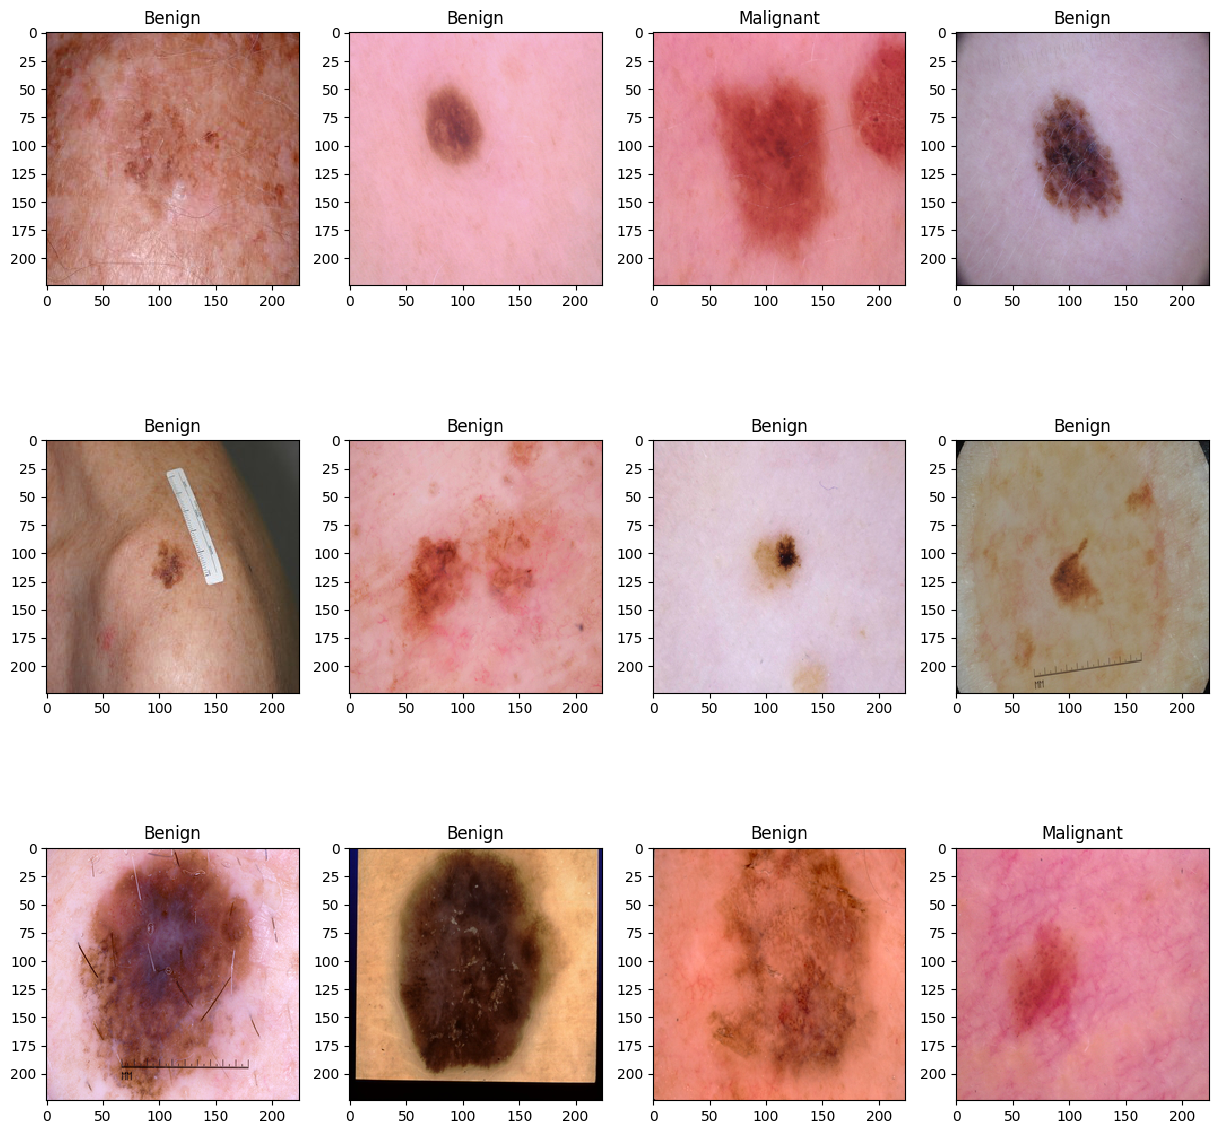

In [ ]:
w=60
h=40
fig=plt.figure(figsize=(15, 15))
columns = 4
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if np.argmax(Y_train[i]) == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(x_train[i], interpolation='nearest')
plt.show()

In [ ]:
# Data Generator
BATCH_SIZE = 64

train_generator = ImageDataGenerator(
        zoom_range=2,
        rotation_range = 90,
        horizontal_flip=True,
        vertical_flip=True,
    )

In [ ]:
# ResNet50 Model
def build_model(backbone, lr=5e-4):
    model = Sequential()
    model.add(backbone)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(2, activation='softmax'))


    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(lr=lr),
        metrics=['accuracy']
    )

    return model

In [ ]:
K.clear_session()
gc.collect()

resnet = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
)

model = build_model(resnet ,lr = 1e-4)
model.summary()

94765736/94765736 [==============================] - 3s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 batch_normalization (BatchN  (None, 2048)             8192      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 2)                 4098      
                                                         

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
learn_control = ReduceLROnPlateau(monitor='val_acc', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)

filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [ ]:
# training and Evaluation
history = model.fit_generator(
    train_generator.flow(x_train, y_train, batch_size=BATCH_SIZE),
    steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
    epochs=50,
    validation_data=(x_val, y_val),
    callbacks=[learn_control, checkpoint]
)

<ipython-input-13-60562f1bc383>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/50
34/33 [==============================] - ETA: 0s - loss: 0.5230 - accuracy: 0.7846

33/33 [==============================] - 63s 1s/step - loss: 0.5230 - accuracy: 0.7846 - val_loss: 1.0791 - val_accuracy: 0.6377 - lr: 1.0000e-04
Epoch 2/50
34/33 [==============================] - ETA: 0s - loss: 0.4204 - accuracy: 0.8271

33/33 [==============================] - 36s 1s/step - loss: 0.4204 - accuracy: 0.8271 - val_loss: 0.9124 - val_accuracy: 0.6566 - lr: 1.0000e-04
Epoch 3/50
34/33 [==============================] - ETA: 0s - loss: 0.3593 - accuracy: 0.8446

33/33 [==============================] - 35s 1s/step - loss: 0.3593 - accuracy: 0.8446 - val_loss: 0.5616 - val_accuracy: 0.7623 - lr: 1.0000e-04
Epoch 4/50
34/33 [==============================] - ETA: 0s - loss: 0.3546 - accuracy: 0.8484

33/33 [==============================] - 37s 1s/step - loss: 0.3546 - accuracy: 0.8484 - val_loss: 0.4378 - val_accuracy: 0.8245 - lr: 1.0000e-04
Epoch 5/50
34/33 [==============================] - ETA: -1s - loss: 0.3394 - accuracy: 0.8399

33/33 [==============================] - 41s 1s/step - loss: 0.3394 - accuracy: 0.8399 - val_loss: 0.3270 - val_accuracy: 0.8849 - lr: 1.0000e-04
Epoch 6/50
34/33 [==============================] - ETA: -1s - loss: 0.2993 - accuracy: 0.8673

33/33 [==============================] - 43s 1s/step - loss: 0.2993 - accuracy: 0.8673 - val_loss: 0.4800 - val_accuracy: 0.8057 - lr: 1.0000e-04
Epoch 7/50
34/33 [==============================] - ETA: 0s - loss: 0.3199 - accuracy: 0.8465

33/33 [==============================] - 38s 1s/step - loss: 0.3199 - accuracy: 0.8465 - val_loss: 0.3198 - val_accuracy: 0.8830 - lr: 1.0000e-04
Epoch 8/50
34/33 [==============================] - ETA: 0s - loss: 0.3086 - accuracy: 0.8668

33/33 [==============================] - 38s 1s/step - loss: 0.3086 - accuracy: 0.8668 - val_loss: 0.4551 - val_accuracy: 0.8434 - lr: 1.0000e-04
Epoch 9/50
34/33 [==============================] - ETA: 0s - loss: 0.3132 - accuracy: 0.8654

33/33 [==============================] - 38s 1s/step - loss: 0.3132 - accuracy: 0.8654 - val_loss: 0.4033 - val_accuracy: 0.8679 - lr: 1.0000e-04
Epoch 10/50
34/33 [==============================] - ETA: 0s - loss: 0.2882 - accuracy: 0.8635

33/33 [==============================] - 38s 1s/step - loss: 0.2882 - accuracy: 0.8635 - val_loss: 0.8068 - val_accuracy: 0.8509 - lr: 1.0000e-04
Epoch 11/50
34/33 [==============================] - ETA: 0s - loss: 0.2756 - accuracy: 0.8781

33/33 [==============================] - 36s 1s/step - loss: 0.2756 - accuracy: 0.8781 - val_loss: 0.2828 - val_accuracy: 0.8887 - lr: 1.0000e-04
Epoch 12/50
34/33 [==============================] - ETA: 0s - loss: 0.2745 - accuracy: 0.8767

33/33 [==============================] - 36s 1s/step - loss: 0.2745 - accuracy: 0.8767 - val_loss: 0.6219 - val_accuracy: 0.8509 - lr: 1.0000e-04
Epoch 13/50
34/33 [==============================] - ETA: 0s - loss: 0.2729 - accuracy: 0.8800

33/33 [==============================] - 38s 1s/step - loss: 0.2729 - accuracy: 0.8800 - val_loss: 0.2700 - val_accuracy: 0.8962 - lr: 1.0000e-04
Epoch 14/50
34/33 [==============================] - ETA: 0s - loss: 0.2605 - accuracy: 0.8753

33/33 [==============================] - 37s 1s/step - loss: 0.2605 - accuracy: 0.8753 - val_loss: 0.3732 - val_accuracy: 0.8868 - lr: 1.0000e-04
Epoch 15/50
34/33 [==============================] - ETA: 0s - loss: 0.2513 - accuracy: 0.8904

33/33 [==============================] - 35s 1s/step - loss: 0.2513 - accuracy: 0.8904 - val_loss: 0.3249 - val_accuracy: 0.8717 - lr: 1.0000e-04
Epoch 16/50
34/33 [==============================] - ETA: 0s - loss: 0.2816 - accuracy: 0.8753

33/33 [==============================] - 36s 1s/step - loss: 0.2816 - accuracy: 0.8753 - val_loss: 1.5652 - val_accuracy: 0.8075 - lr: 1.0000e-04
Epoch 17/50
34/33 [==============================] - ETA: 0s - loss: 0.2618 - accuracy: 0.8838

33/33 [==============================] - 38s 1s/step - loss: 0.2618 - accuracy: 0.8838 - val_loss: 0.3616 - val_accuracy: 0.8849 - lr: 1.0000e-04
Epoch 18/50
34/33 [==============================] - ETA: 0s - loss: 0.2836 - accuracy: 0.8748

33/33 [==============================] - 38s 1s/step - loss: 0.2836 - accuracy: 0.8748 - val_loss: 0.2565 - val_accuracy: 0.9019 - lr: 1.0000e-04
Epoch 19/50
34/33 [==============================] - ETA: 0s - loss: 0.2456 - accuracy: 0.8918

33/33 [==============================] - 37s 1s/step - loss: 0.2456 - accuracy: 0.8918 - val_loss: 0.2270 - val_accuracy: 0.8925 - lr: 1.0000e-04
Epoch 20/50
34/33 [==============================] - ETA: 0s - loss: 0.2346 - accuracy: 0.8956

33/33 [==============================] - 36s 1s/step - loss: 0.2346 - accuracy: 0.8956 - val_loss: 0.2394 - val_accuracy: 0.8830 - lr: 1.0000e-04
Epoch 21/50
34/33 [==============================] - ETA: 0s - loss: 0.2433 - accuracy: 0.8829

33/33 [==============================] - 38s 1s/step - loss: 0.2433 - accuracy: 0.8829 - val_loss: 0.2994 - val_accuracy: 0.8660 - lr: 1.0000e-04
Epoch 22/50
34/33 [==============================] - ETA: 0s - loss: 0.2422 - accuracy: 0.8984

33/33 [==============================] - 39s 1s/step - loss: 0.2422 - accuracy: 0.8984 - val_loss: 0.2642 - val_accuracy: 0.8830 - lr: 1.0000e-04
Epoch 23/50
34/33 [==============================] - ETA: 0s - loss: 0.2147 - accuracy: 0.9084

33/33 [==============================] - 37s 1s/step - loss: 0.2147 - accuracy: 0.9084 - val_loss: 0.2769 - val_accuracy: 0.8811 - lr: 1.0000e-04
Epoch 24/50
34/33 [==============================] - ETA: 0s - loss: 0.2406 - accuracy: 0.8980

33/33 [==============================] - 37s 1s/step - loss: 0.2406 - accuracy: 0.8980 - val_loss: 0.2925 - val_accuracy: 0.8811 - lr: 1.0000e-04
Epoch 25/50
34/33 [==============================] - ETA: 0s - loss: 0.2289 - accuracy: 0.9022

33/33 [==============================] - 38s 1s/step - loss: 0.2289 - accuracy: 0.9022 - val_loss: 0.2229 - val_accuracy: 0.9038 - lr: 1.0000e-04
Epoch 26/50
34/33 [==============================] - ETA: 0s - loss: 0.2293 - accuracy: 0.8975

33/33 [==============================] - 36s 1s/step - loss: 0.2293 - accuracy: 0.8975 - val_loss: 0.2627 - val_accuracy: 0.8868 - lr: 1.0000e-04
Epoch 27/50
34/33 [==============================] - ETA: 0s - loss: 0.2233 - accuracy: 0.9036

33/33 [==============================] - 37s 1s/step - loss: 0.2233 - accuracy: 0.9036 - val_loss: 0.2419 - val_accuracy: 0.9075 - lr: 1.0000e-04
Epoch 28/50
34/33 [==============================] - ETA: 0s - loss: 0.2125 - accuracy: 0.9036

33/33 [==============================] - 37s 1s/step - loss: 0.2125 - accuracy: 0.9036 - val_loss: 0.3198 - val_accuracy: 0.8792 - lr: 1.0000e-04
Epoch 29/50
34/33 [==============================] - ETA: 0s - loss: 0.2163 - accuracy: 0.9084

33/33 [==============================] - 36s 1s/step - loss: 0.2163 - accuracy: 0.9084 - val_loss: 0.3786 - val_accuracy: 0.8491 - lr: 1.0000e-04
Epoch 30/50
34/33 [==============================] - ETA: 0s - loss: 0.2020 - accuracy: 0.9088

33/33 [==============================] - 37s 1s/step - loss: 0.2020 - accuracy: 0.9088 - val_loss: 0.3100 - val_accuracy: 0.9000 - lr: 1.0000e-04
Epoch 31/50
34/33 [==============================] - ETA: 0s - loss: 0.1845 - accuracy: 0.9263

33/33 [==============================] - 38s 1s/step - loss: 0.1845 - accuracy: 0.9263 - val_loss: 0.3002 - val_accuracy: 0.8830 - lr: 1.0000e-04
Epoch 32/50
34/33 [==============================] - ETA: 0s - loss: 0.2114 - accuracy: 0.9084

33/33 [==============================] - 37s 1s/step - loss: 0.2114 - accuracy: 0.9084 - val_loss: 0.2572 - val_accuracy: 0.9038 - lr: 1.0000e-04
Epoch 33/50
34/33 [==============================] - ETA: 0s - loss: 0.2068 - accuracy: 0.9131

33/33 [==============================] - 35s 1s/step - loss: 0.2068 - accuracy: 0.9131 - val_loss: 0.2903 - val_accuracy: 0.8981 - lr: 1.0000e-04
Epoch 34/50
34/33 [==============================] - ETA: 0s - loss: 0.2498 - accuracy: 0.8961

33/33 [==============================] - 36s 1s/step - loss: 0.2498 - accuracy: 0.8961 - val_loss: 0.2432 - val_accuracy: 0.9113 - lr: 1.0000e-04
Epoch 35/50
34/33 [==============================] - ETA: 0s - loss: 0.1940 - accuracy: 0.9206

33/33 [==============================] - 35s 1s/step - loss: 0.1940 - accuracy: 0.9206 - val_loss: 0.2678 - val_accuracy: 0.8981 - lr: 1.0000e-04
Epoch 36/50
34/33 [==============================] - ETA: 0s - loss: 0.2110 - accuracy: 0.9140

33/33 [==============================] - 37s 1s/step - loss: 0.2110 - accuracy: 0.9140 - val_loss: 0.2180 - val_accuracy: 0.9208 - lr: 1.0000e-04
Epoch 37/50
34/33 [==============================] - ETA: 0s - loss: 0.2025 - accuracy: 0.9079

33/33 [==============================] - 36s 1s/step - loss: 0.2025 - accuracy: 0.9079 - val_loss: 0.3864 - val_accuracy: 0.8566 - lr: 1.0000e-04
Epoch 38/50
34/33 [==============================] - ETA: -1s - loss: 0.2000 - accuracy: 0.9173

33/33 [==============================] - 40s 1s/step - loss: 0.2000 - accuracy: 0.9173 - val_loss: 0.2382 - val_accuracy: 0.9113 - lr: 1.0000e-04
Epoch 39/50
34/33 [==============================] - ETA: 0s - loss: 0.1894 - accuracy: 0.9221

33/33 [==============================] - 36s 1s/step - loss: 0.1894 - accuracy: 0.9221 - val_loss: 0.4324 - val_accuracy: 0.8811 - lr: 1.0000e-04
Epoch 40/50
34/33 [==============================] - ETA: 0s - loss: 0.2055 - accuracy: 0.9107

33/33 [==============================] - 35s 1s/step - loss: 0.2055 - accuracy: 0.9107 - val_loss: 0.5551 - val_accuracy: 0.8623 - lr: 1.0000e-04
Epoch 41/50
34/33 [==============================] - ETA: 0s - loss: 0.1978 - accuracy: 0.9164

33/33 [==============================] - 37s 1s/step - loss: 0.1978 - accuracy: 0.9164 - val_loss: 0.4303 - val_accuracy: 0.8906 - lr: 1.0000e-04
Epoch 42/50
34/33 [==============================] - ETA: 0s - loss: 0.1916 - accuracy: 0.9145

33/33 [==============================] - 36s 1s/step - loss: 0.1916 - accuracy: 0.9145 - val_loss: 0.2385 - val_accuracy: 0.9038 - lr: 1.0000e-04
Epoch 43/50
34/33 [==============================] - ETA: 0s - loss: 0.2015 - accuracy: 0.9159

33/33 [==============================] - 36s 1s/step - loss: 0.2015 - accuracy: 0.9159 - val_loss: 0.3663 - val_accuracy: 0.8962 - lr: 1.0000e-04
Epoch 44/50
34/33 [==============================] - ETA: 0s - loss: 0.2143 - accuracy: 0.9093

33/33 [==============================] - 37s 1s/step - loss: 0.2143 - accuracy: 0.9093 - val_loss: 0.3155 - val_accuracy: 0.8547 - lr: 1.0000e-04
Epoch 45/50
34/33 [==============================] - ETA: 0s - loss: 0.1966 - accuracy: 0.9079

33/33 [==============================] - 38s 1s/step - loss: 0.1966 - accuracy: 0.9079 - val_loss: 0.3385 - val_accuracy: 0.8736 - lr: 1.0000e-04
Epoch 46/50
34/33 [==============================] - ETA: 0s - loss: 0.1822 - accuracy: 0.9244

33/33 [==============================] - 37s 1s/step - loss: 0.1822 - accuracy: 0.9244 - val_loss: 0.4474 - val_accuracy: 0.8774 - lr: 1.0000e-04
Epoch 47/50
34/33 [==============================] - ETA: 0s - loss: 0.1890 - accuracy: 0.9140

33/33 [==============================] - 38s 1s/step - loss: 0.1890 - accuracy: 0.9140 - val_loss: 0.2354 - val_accuracy: 0.9075 - lr: 1.0000e-04
Epoch 48/50
34/33 [==============================] - ETA: 0s - loss: 0.1687 - accuracy: 0.9339

33/33 [==============================] - 36s 1s/step - loss: 0.1687 - accuracy: 0.9339 - val_loss: 0.4774 - val_accuracy: 0.8528 - lr: 1.0000e-04
Epoch 49/50
34/33 [==============================] - ETA: 0s - loss: 0.1844 - accuracy: 0.9164

33/33 [==============================] - 36s 1s/step - loss: 0.1844 - accuracy: 0.9164 - val_loss: 0.4399 - val_accuracy: 0.8698 - lr: 1.0000e-04
Epoch 50/50
34/33 [==============================] - ETA: 0s - loss: 0.1625 - accuracy: 0.9339

33/33 [==============================] - 35s 1s/step - loss: 0.1625 - accuracy: 0.9339 - val_loss: 0.6981 - val_accuracy: 0.8132 - lr: 1.0000e-04


In [ ]:
Y_val_pred = model.predict(x_val)
accuracy_score(np.argmax(y_val, axis=1), np.argmax(Y_val_pred, axis=1))

17/17 [==============================] - 3s 101ms/step


0.8132075471698114

21/21 [==============================] - 3s 145ms/step
Confusion matrix, without normalization
[[249 111]
 [ 19 281]]


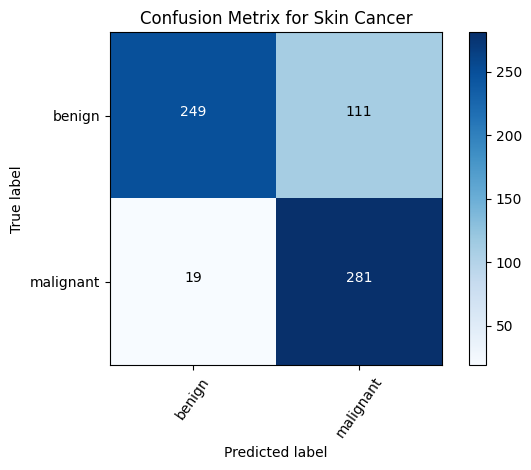

In [ ]:
# confusion metric
Y_pred = model.predict(X_test)
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=55)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cm = confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1))

cm_plot_label =['benign', 'malignant']
plot_confusion_matrix(cm, cm_plot_label, title ='Confusion Metrix for Skin Cancer')


  0%|          | 0/10 [00:00<?, ?it/s]<ipython-input-23-d952b9ab7d5e>:6: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  preds = model.predict_generator(train_generator.flow(X_test, batch_size=BATCH_SIZE, shuffle=False),
100%|██████████| 10/10 [01:45<00:00, 10.50s/it]


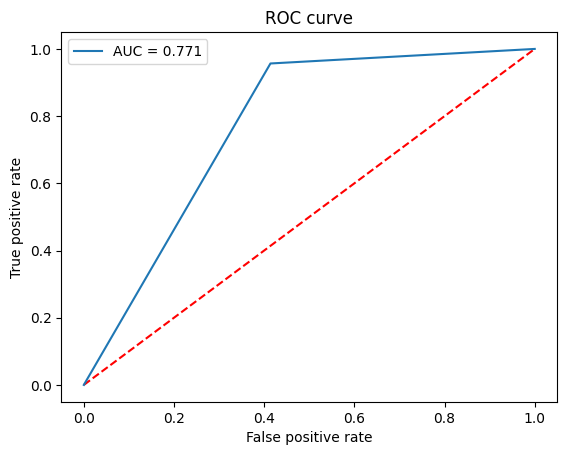

In [ ]:
# ROC & AUC
tta_steps = 10
predictions = []

for i in tqdm(range(tta_steps)):
    preds = model.predict_generator(train_generator.flow(X_test, batch_size=BATCH_SIZE, shuffle=False),
                                    steps = len(X_test)/BATCH_SIZE)

    predictions.append(preds)
    gc.collect()

Y_pred_tta = np.mean(predictions, axis=0)
from sklearn.metrics import roc_auc_score, auc
from sklearn.metrics import roc_curve
roc_log = roc_auc_score(np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))
false_positive_rate, true_positive_rate, threshold = roc_curve(np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))
area_under_curve = auc(false_positive_rate, true_positive_rate)

plt.plot([0, 1], [0, 1], 'r--')
plt.plot(false_positive_rate, true_positive_rate, label='AUC = {:.3f}'.format(area_under_curve))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
plt.close()


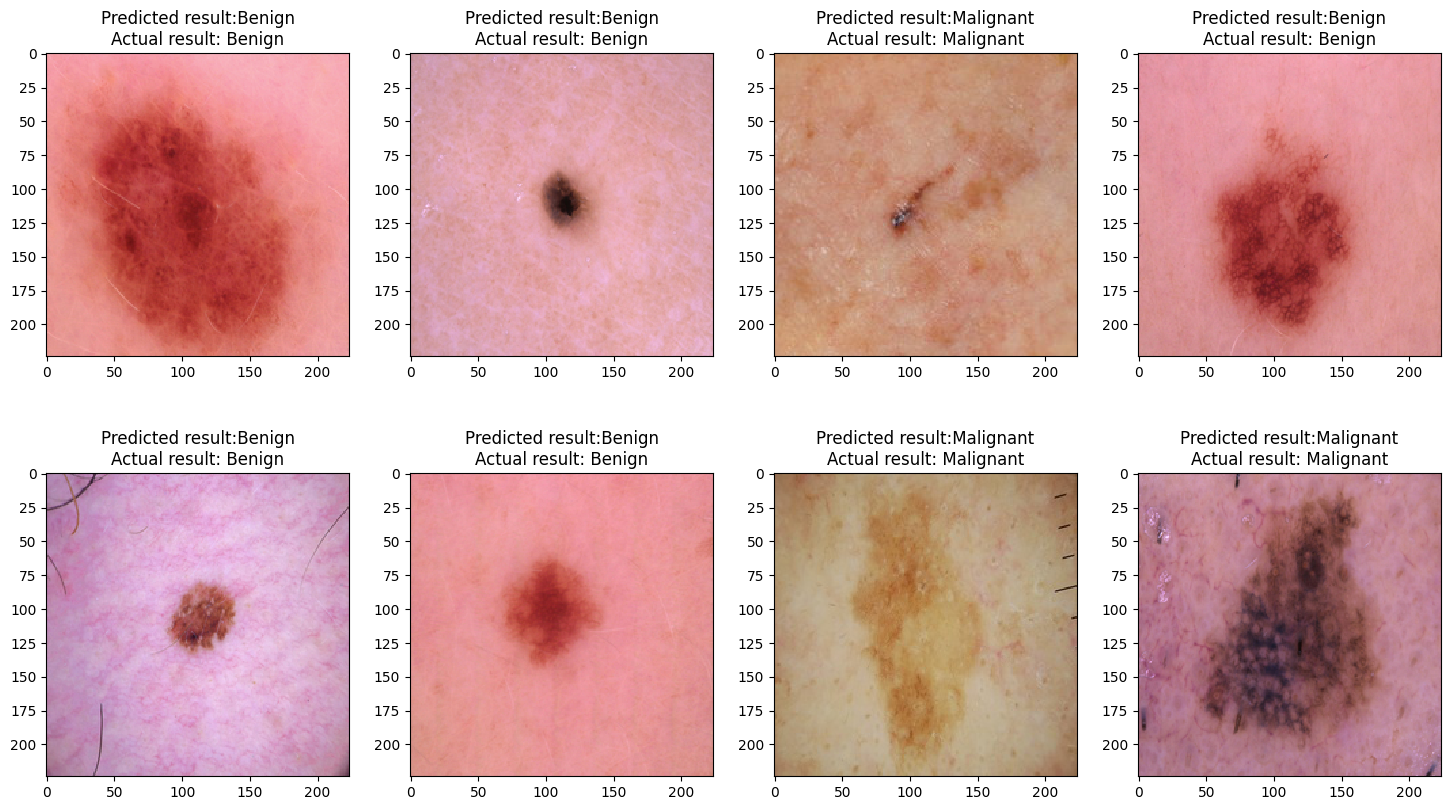

In [ ]:

i=0
prop_class=[]
mis_class=[]

for i in range(len(Y_test)):
    if(np.argmax(Y_test[i])==np.argmax(Y_pred_tta[i])):
        prop_class.append(i)
    if(len(prop_class)==8):
        break

i=0
for i in range(len(Y_test)):
    if(not np.argmax(Y_test[i])==np.argmax(Y_pred_tta[i])):
        mis_class.append(i)
    if(len(mis_class)==8):
        break

w=60
h=40
fig=plt.figure(figsize=(18, 10))
columns = 4
rows = 2

def Transfername(namecode):
    if namecode==0:
        return "Benign"
    else:
        return "Malignant"

for i in range(len(prop_class)):
    ax = fig.add_subplot(rows, columns, i+1)
    ax.set_title("Predicted result:"+ Transfername(np.argmax(Y_pred_tta[prop_class[i]]))
                       +"\n"+"Actual result: "+ Transfername(np.argmax(Y_test[prop_class[i]])))
    plt.imshow(X_test[prop_class[i]], interpolation='nearest')
plt.show()